In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('CropYield.csv')

In [3]:
provinces = ['Ha_Noi', 'Hai_Duong', 'Hung_Yen', 'Nam_Dinh', 'Ninh_Binh', 'Thai_Binh', 'Ha_Nam', 'Thanh_Hoa', 'Nghe_An', 'Ha_Tinh', 'Quang_Binh', 'Quang_Tri', 'Hue', 'Long_An', 'Tien_Giang', 'Ben_Tre', 'Tra_Vinh', 'Dong_Thap', 'An_Giang', 'Kien_Giang', 'Can_Tho', 'Soc_Trang', 'Bac_Lieu', 'Ca_Mau']
colors = ['rosybrown', 'lightcoral', 'maroon', 'red', 'tomato', 'darksalmon', 'sienna', 'chocolate', 'orange', 'darkgoldenrod', 'darkolivegreen', 'darkseagreen', 'turquoise', 'darkcyan', 'deepskyblue', 'slategray', 'cornflowerblue', 'navy', 'slateblue', 'blueviolet', 'mediumorchid', 'darkmagenta', 'mediumvioletred', 'crimson', 'lightpink']

Model built on Training Set in order to determine which degree leads to best MSE on Testing Set

In [4]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1)

def MSE(X, y):
    
    X = np.array(X)
    y = np.array(y)
    
    MSE_validation = 0
    
    for (train_index, test_index) in (tscv.split(X)):
        
        linear_model = LinearRegression().fit(X[train_index], y[train_index])
        
        MSE_validation += mean_squared_error(y_true=y[test_index], y_pred=linear_model.predict(X[test_index]))
        
        del linear_model

    return MSE_validation/5

In [5]:
def best_degree(X, y):

    ans = 0

    best_mse = 99999999
    
    for degree in range(1, 20):

        poly = PolynomialFeatures(degree=degree, include_bias=False)

        X_poly = poly.fit_transform(X)

        MSE_test = MSE(X=X_poly, y=y)

        if (MSE_test < best_mse):
            ans = degree
            best_mse = MSE_test
    
    return ans

In [6]:
degrees = []

for province in provinces:

    X = np.arange(0, 26).reshape(-1, 1)

    y = df.loc[df['Province'] == province]['CropYield']
    
    degrees.append(best_degree(X, y))


degrees

[2, 3, 3, 1, 3, 2, 3, 3, 3, 2, 3, 1, 3, 3, 1, 2, 1, 2, 4, 2, 1, 3, 1, 1]

In [7]:
# degrees = [3, 3, 3, 3, 3, 3, 3]

In [8]:
table = pd.DataFrame()

cols = ['Year', 'Province', 'RandomCropYield']

for i, col in enumerate(cols):
    table.insert(i, col, None)

table

,Year,Province,RandomCropYield


In [9]:
def export(province, random_yield):
    
    for year in range(1995, 2021):
        row = [year, province]

        row.append(random_yield[year - 1995])

        table.loc[len(table)] = row

In [10]:
def yield_trend(degree, province):
    X = np.arange(0, 26).reshape(-1, 1)

    y = df.loc[df['Province'] == province]['CropYield']

    X_poly = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X)

    linear_model = LinearRegression().fit(X_poly, y)

    y_predicted = linear_model.predict(X_poly)

    export(province=province, random_yield=list(y - y_predicted))

    return (y_predicted, linear_model.coef_, linear_model.intercept_)

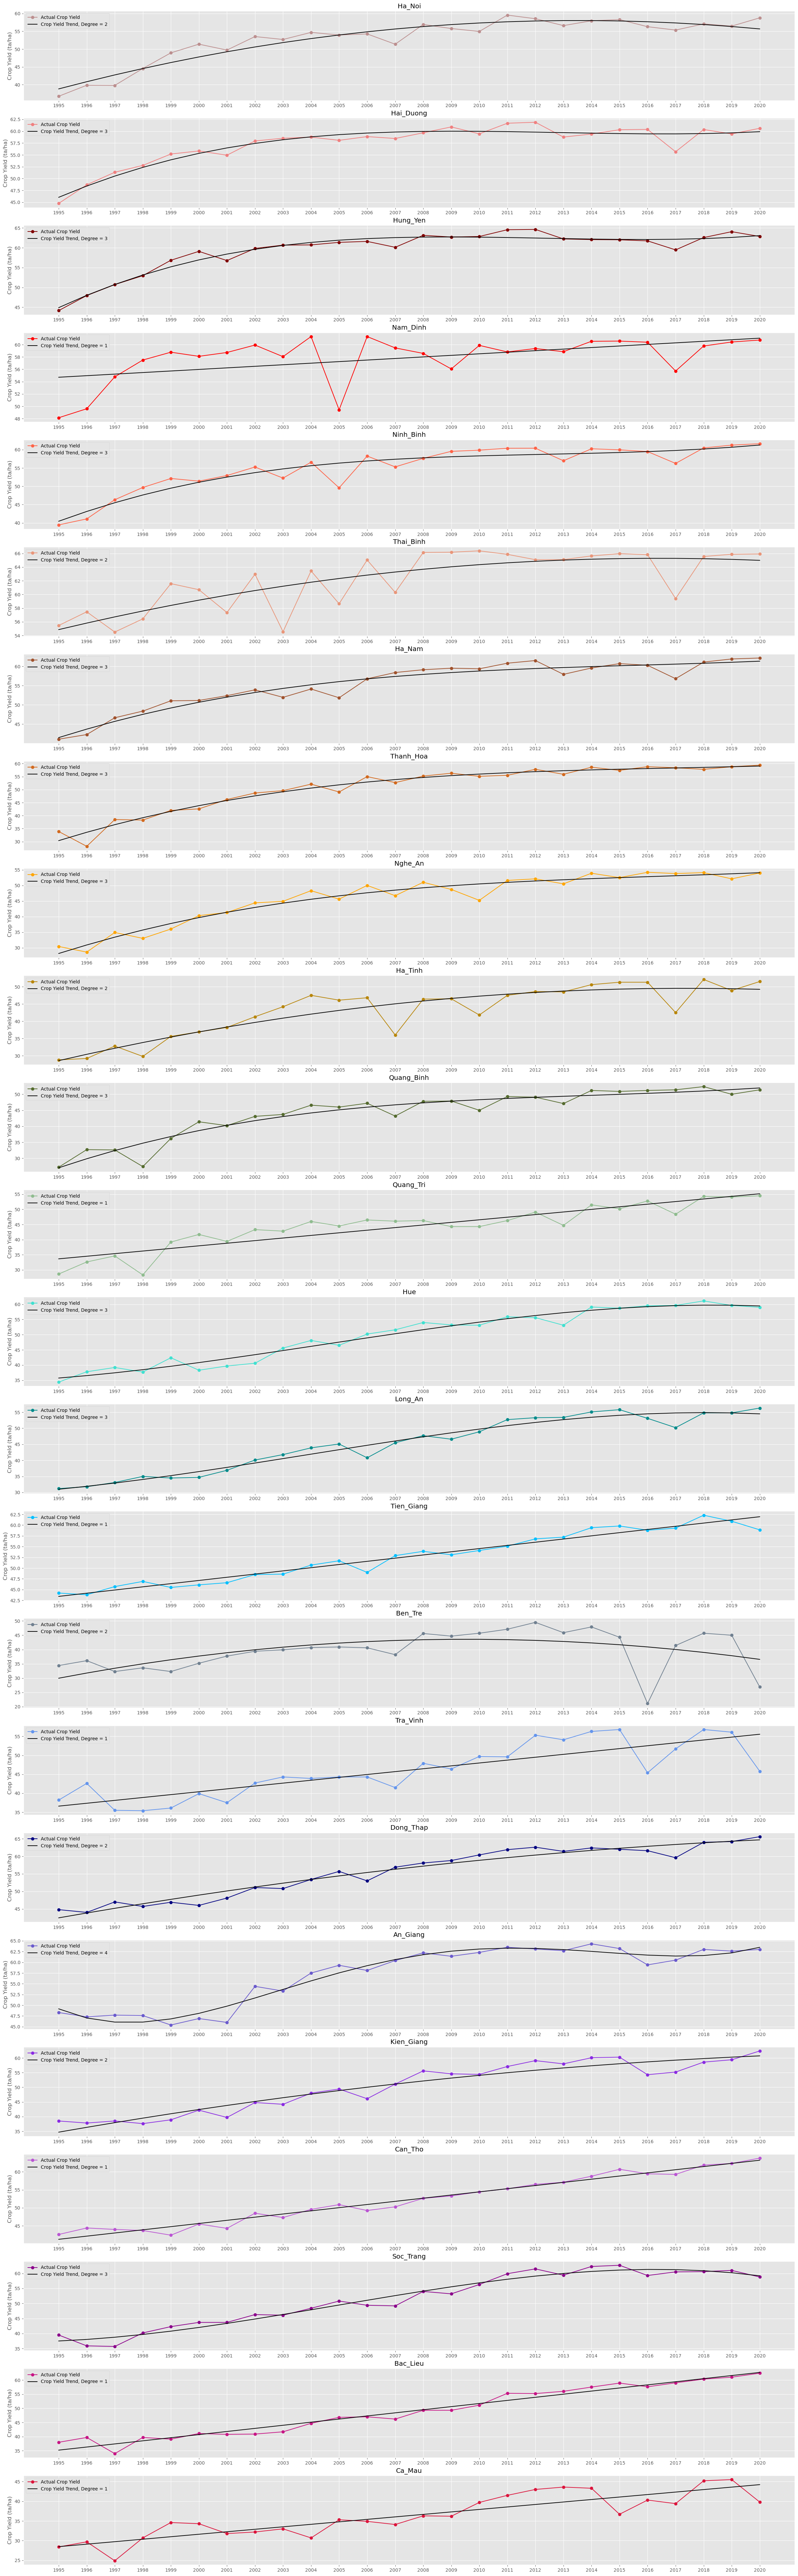

In [11]:
coefs = []
intercepts = []

nrows = 24
ncols = 1

plt.style.use('ggplot') 

fig = plt.figure(figsize=(30, 100))

for id, province in enumerate(provinces):
    
    crop_yield_trend, coef, intercept = yield_trend(degree=degrees[id], province=province)

    #Collect coefficients & intercepts
    coefs.append(coef)
    intercepts.append(intercept)

    #Plotting crop yield trend, and comparing with actual crop yield
    actual_crop_yield = df.loc[df['Province'] == province]['CropYield']

    ax = fig.add_subplot(nrows, ncols, id + 1)
    ax.plot(np.arange(1995, 2021), actual_crop_yield, marker='o', c=colors[id], label='Actual Crop Yield')
    ax.plot(np.arange(1995, 2021), crop_yield_trend, c='black', label='Crop Yield Trend, Degree = ' + str(degrees[id]))

    ax.legend()
    ax.set_xticks(np.arange(1995, 2021, dtype=int), list(map(str, list(np.arange(1995, 2021)))))
    ax.set_title(province)

    # ax.set_xlabel('Year') 
    ax.set_ylabel('Crop Yield (ta/ha)')

    del actual_crop_yield

# plt.legend()
plt.show()


In [12]:
for i, province in enumerate(provinces):
    print(province, degrees[i], coefs[i], intercepts[i])

Ha_Noi 2 [ 2.07522366 -0.05603951] 38.82044522275337
Hai_Duong 3 [ 2.52485698 -0.14773112  0.00275604] 46.04301939041797
Hung_Yen 3 [ 3.30389534 -0.19847893  0.00381441] 44.90008279940945
Nam_Dinh 1 [0.25324716] 54.71141925589743
Ninh_Binh 3 [ 2.82103025 -0.1524669   0.00291736] 40.44689986226086
Thai_Binh 2 [ 0.97480132 -0.02279325] 54.86007164916362
Ha_Nam 3 [ 2.30147796e+00 -1.00822947e-01  1.62220913e-03] 41.48485439042173
Thanh_Hoa 3 [ 3.33955273e+00 -1.40838711e-01  2.12468552e-03] 30.39458970148617
Nghe_An 3 [ 2.84815613e+00 -1.17997741e-01  1.82173870e-03] 28.152524104248137
Ha_Tinh 2 [ 1.87508303 -0.04193529] 28.576556776556792
Quang_Binh 3 [ 2.96151524e+00 -1.39282456e-01  2.43060094e-03] 27.019649698960006
Quang_Tri 1 [0.86167521] 33.62905982905983
Hue 3 [ 0.72798593  0.06975882 -0.00243761] 35.73304702959881
Long_An 3 [ 0.85318611  0.06092997 -0.00229847] 30.99815165677245
Tien_Giang 1 [0.74140171] 43.41709401709403
Ben_Tre 2 [ 1.87287179 -0.06435897] 29.961538461538474
Tra

In [14]:
table.loc[table['Year'] >= 2000].to_csv('RandomCropYield(Regression).csv', index=False)